## This code is used to generate coarse water map by using optical sentinel-2 image


In [1]:
import sys
sys.path.append("/home/yons/Desktop/developer-luo/SWatNet")

import tensorflow as tf
from utils.tiff_io import readTiff, writeTiff
from utils.imgShow import imgShow
from utils.imgPatch import imgPatch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


In [2]:
# sen1&sen2 images
root_dir = os.path.dirname(os.getcwd())
scene_num = 'scene07'
path_S2_img = root_dir + '/data/s2_img_truth/' + scene_num+ '_s2_img.tif'
path_water_map = root_dir + '/data/s2_img_truth/'+ scene_num + '_wat_truth.tif'
s2_image, geotrans_s2, proj_s2, row_s2, col_s2, bands_s2 = readTiff(path_in=path_S2_img)
# cla_map, _, _, _, _, _ = readTiff(path_in=path_water_map)

s2_image = np.float32(np.clip(s2_image/10000, a_min=0, a_max=1))    ### normalization
print(row_s2, col_s2)


3296 3519


In [4]:
# pre-trained model
path_model = root_dir + '/models/pretrained/WatNet.h5'
# super parameters
model = tf.keras.models.load_model(path_model)  # load model


In [5]:
# surface water mapping from sentinel-2 image
imgPat_ins = imgPatch(img=s2_image ,patch_size=512, overlay = 160)
patch_list, img_patch_row, img_patch_col = imgPat_ins.toPatch()
result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]
result_patch_list = [np.squeeze(patch, axis = 0) for patch in result_patch_list]
pro_map = imgPat_ins.toImage(result_patch_list, img_patch_row, img_patch_col)
cla_map = np.where(pro_map>0.5, 1, 0)


In [6]:
## mask the outer truth map values
edge_mask = 896
s2_image_mask, cla_map_mask = np.zeros_like(s2_image), np.zeros_like(cla_map)
s2_image_mask[edge_mask:-edge_mask, edge_mask:-edge_mask] = s2_image[edge_mask:-edge_mask, edge_mask:-edge_mask]
cla_map_mask[edge_mask:-edge_mask, edge_mask:-edge_mask] = cla_map[edge_mask:-edge_mask, edge_mask:-edge_mask]


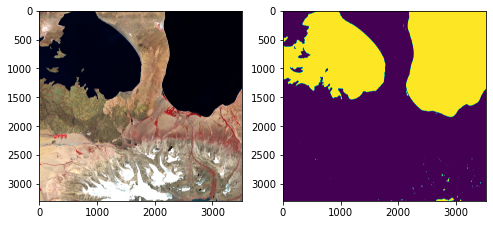

In [10]:
cla_map, _, _, _, _, _ = readTiff(path_in=path_water_map)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
imgShow(s2_image, (3,2,1), 5)
plt.subplot(1,2,2)
imgShow(cla_map, (0,0,0), 1)


In [ ]:
# save the result
# writeTiff(cla_map[:,:,0], geotrans_s2, proj_s2, path_water_map)


(3099, 3223, 6)


Text(0.5, 1.0, 'truth water')

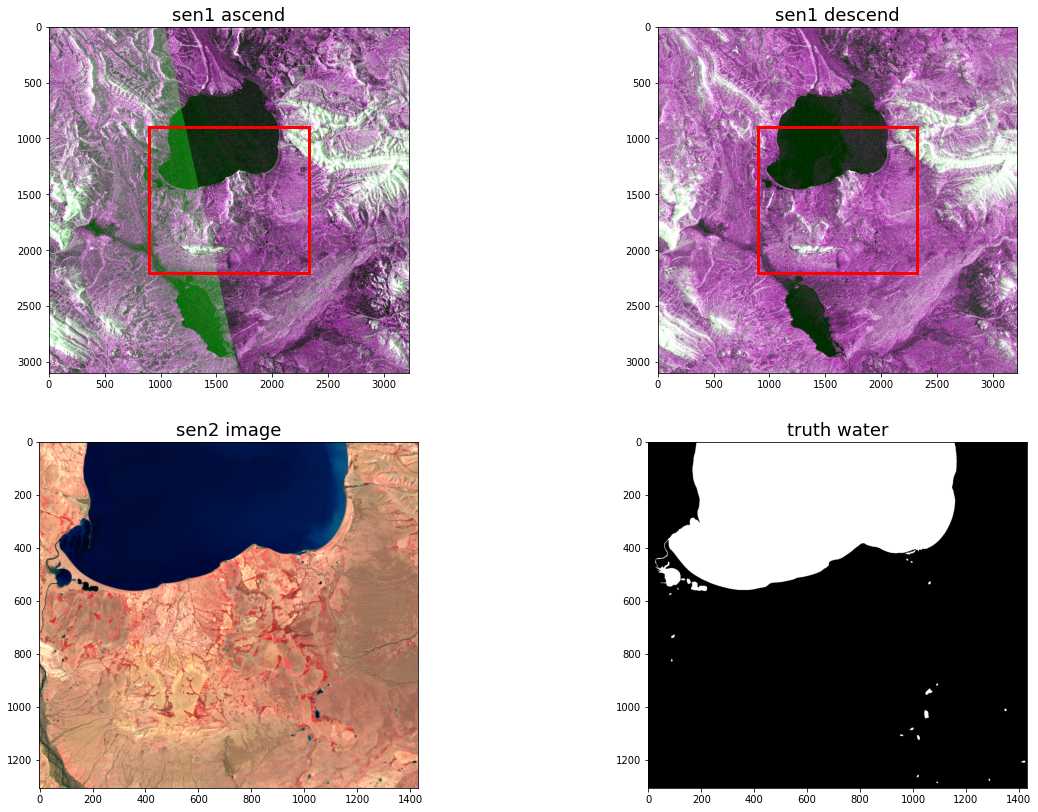

In [12]:
## select the sample
## 15/20(01,02,03,04,05,06,07,08,09,10,11,12,13,14,15) scenes for training
## 5/20(16,17,18,19,20) scenes for validation
scene_num = 'scene05'
path_s2_img = root_dir + '/data/s2_img_truth/'+scene_num+'_s2_img.tif'
path_water_truth = root_dir + '/data/s2_img_truth/'+scene_num+'_wat_truth.tif'
path_s1_ascend = root_dir + '/data/s1_ascend/'+scene_num+ '_s1_ascend.tif'
path_s1_descend = root_dir + '/data/s1_descend/'+scene_num + '_s1_descend.tif'

## read the sentinel-1 image
s2_image, geotrans_s2, proj_s2, row_s2, col_s2, _ = readTiff(path_in=path_s2_img)
water_truth, _, _, _, _, _ = readTiff(path_in=path_water_truth)
s1_ascend, _, _, _, _, _ = readTiff(path_in=path_s1_ascend)
s1_descend, _, _, _, _, _ = readTiff(path_in=path_s1_descend)

## Visualize the sentinel-1 sentinel-2 and truth water map.
print(s2_image.shape)
plt.figure(figsize=(20,14))

plt.subplot(2,2,1)
imgShow(s1_ascend, (0,1,0), 5, per_band_clip='True')
plt.title('sen1 ascend', fontsize=18, color='black')
rect = patches.Rectangle((896,896), width=col_s2-1792, 
                height=row_s2-1792, linewidth=3, edgecolor='red', fill=False)
ax_1 = plt.gca()
ax_1.add_patch(rect)

plt.subplot(2,2,2)
imgShow(s1_descend, (0,1,0), 5, per_band_clip='True')
plt.title('sen1 descend', fontsize=18, color='black')
rect = patches.Rectangle((896,896), width=col_s2-1792,
                height=row_s2-1792, linewidth=3, edgecolor='red', fill=False)
ax_2 = plt.gca()
ax_2.add_patch(rect)

plt.subplot(2,2,3)
imgShow(s2_image[896:-896, 896:-896], (3,2,1), 2)
plt.title('sen2 image', fontsize=18, color='black')

plt.subplot(2,2,4)
plt.imshow(water_truth[896:-896, 896:-896], cmap='gray')
plt.title('truth water', fontsize=18, color='black')
